# Review of classical electronic structure methods 

In order to assess the performance of quantum computing algorithms in addressing the electronic structure problem, we will briefly review a few commonly employed classical electronic structure methods of varying level of approximation. 

## Hartree-Fock

The Hartree-Fock (HF) method employs a **mean-field approximation**, where Coulomb correlation of electrons is neglected. The HF wavefunction is hence restricted to the form of a single Slater determinant, for which the optimal form may be acquired by an optimization of the underlying single particle basis (orbitals). Once the optimal HF orbitals have been found, the HF state may be written as 

$$ | \text{HF} \rangle = \prod_{p \in \text{occ}} \hat a^\dagger_p | \text{vac} \rangle $$

where $\hat a^\dagger_p$ creates an electron in the $p^{\rm{th}}$ optimized HF spin orbital, and  $| \text{vac} \rangle$ is the vacuum state (all spin-orbitals unoccupied). Due to the restriction to a single Slater determinant, the HF energy may be obtained very efficiently and can be applied to very large molecules, however it becomes qualitatively incorrect when **electronic correlations** become sufficiently strong. The HF wavefunction is often used as a starting point in more accurate treatments of electronic correlation. 

## Coupled cluster

The Coupled cluster (CC) method introduces electronic correlation to the wavefunction ansatz by operating on the HF reference state with the exponential of excitation operators

$$|\text{CC} \rangle = e^{\hat T} | \text{HF}\rangle, \quad \hat T = \hat T_1 + \hat T_2 + ...$$

where $\hat T_1 = \sum_{ia} t^{a}_i \hat a^\dagger_a \hat a_i$ are referred to as 'singles', $\hat T_2 = \sum_{ijab} t^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j$ as 'doubles', etc. When the excitation rank is truncated to only singles (S) and doubles (D), $\hat T = \hat T_1 + \hat T_2$, the corresponding ansatz is referred to as CCSD. Since the number of possible single and double excitations for a system of $N$ electrons in $M$ orbitals is polynomial in $M$, one can efficiently solve a system of equations to obtain the optimized CCSD amplitudes. CCSD often gives accurate energies and can be applied to modestly sized chemical systems. However, due to its implementation, it can **violate the variational principle** and give energies lower than the ground state.

## Full Configuration Interaction
The full configuration interaction (FCI) method yields the **exact ground state energy** within a given basis set. The FCI wavefunction is written as a linear combination of all possible $N$-particle Slater determinants over the orbital basis
$$|\text{FCI} \rangle =  \left( \sum_{ia} C^{a}_i \hat a^\dagger_a \hat a_i + \sum_{ijab} C^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j + ...  \right) | \text{HF} \rangle $$
where the sum includes up to $N$-electron excitations, and hence there are an exponential number of coefficients to optimize in $| \text{FCI} \rangle$. Due to its **exponential complexity**, FCI is often reserved for only the smallest chemical systems. However, it serves as a useful result to compare to when assessing tractable electronic structure methods.

# Benchmarking for electronic PESs in minimal basis (STO-3G)

We will apply HF, CCSD, and FCI to obtaining the PESs for a few molecular dissociation processes in minimal (STO-3G) basis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utility import get_molecular_data, obtain_PES

'''
Basis functions are provided to initialization using a string such as '6-31g'
The most widely used basis set is STO-3G, which is used for large systems and for preliminary geometry determinations.
'''
basis = 'sto-3g' #3 primitive Gaussian orbitals are fitted to a single Slater-type orbital (STO)

/home/bencian/.local/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


## H<sub>2</sub>

In [2]:
bond_lengths = np.linspace(0.2,2.6,15)
bond_lengths #in Angstroms

array([0.2       , 0.37142857, 0.54285714, 0.71428571, 0.88571429,
       1.05714286, 1.22857143, 1.4       , 1.57142857, 1.74285714,
       1.91428571, 2.08571429, 2.25714286, 2.42857143, 2.6       ])

In [3]:
#Run FCI
FCI_PES = obtain_PES('h2', bond_lengths, basis, method='fci') #returns energy in Hartrees

E = 0.15748213365503272 Eh
E = -0.8488991062024303 Eh
E = -1.0882281844069168 Eh
E = -1.136928959400571 Eh
E = -1.1229570527982327 Eh
E = -1.0887645364963472 Eh
E = -1.050442037218747 Eh
E = -1.0154682491653277 Eh
E = -0.987392996293216 Eh
E = -0.9670259116093083 Eh
E = -0.9534242125062942 Eh
E = -0.9449089870950516 Eh
E = -0.9398197912188275 Eh
E = -0.9368706035283361 Eh
E = -0.9351960308386078 Eh


In [4]:
#Run HF
HF_PES = obtain_PES('h2', bond_lengths, basis,  method='hf')

E = 0.16412595411335862 Eh
E = -0.8397057843499789 Eh
E = -1.074887931719117 Eh
E = -1.1175258568986912 Eh
E = -1.0951595815644795 Eh
E = -1.0495617842752072 Eh
E = -0.9960202460350677 Eh
E = -0.9415475409906814 Eh
E = -0.8899750208893146 Eh
E = -0.8432718025417755 Eh
E = -0.8022428650141384 Eh
E = -0.7669825247359998 Eh
E = -0.7371545448988288 Eh
E = -0.7121961606082431 Eh
E = -0.6914700512624794 Eh


In [5]:
#Run CCSD
CCSD_PES = obtain_PES('h2', bond_lengths, basis,  method='ccsd')

E = 0.15748412056436217 Eh
E = -0.8488985094851161 Eh
E = -1.0882310174307857 Eh
E = -1.1369333351418656 Eh
E = -1.1229593878059763 Eh
E = -1.0887606905920533 Eh
E = -1.050426089327126 Eh
E = -1.015441636439638 Eh
E = -0.9873692257052735 Eh
E = -0.9670168314563374 Eh
E = -0.9534301294889956 Eh
E = -0.9449225613845066 Eh
E = -0.9398332746700124 Eh
E = -0.9368793989542732 Eh
E = -0.9351989265367034 Eh


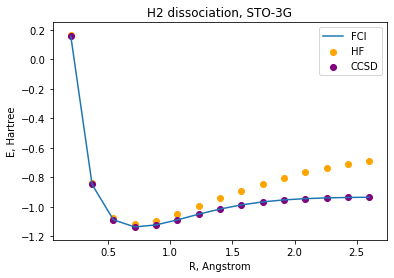

In [6]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

<img src="figs/testimage.png">

## H<sub>2</sub>O symmetric O-H dissociation

In [7]:
bond_lengths = np.linspace(0.5,2.7,15)
bond_lengths

array([0.5       , 0.65714286, 0.81428571, 0.97142857, 1.12857143,
       1.28571429, 1.44285714, 1.6       , 1.75714286, 1.91428571,
       2.07142857, 2.22857143, 2.38571429, 2.54285714, 2.7       ])

In [8]:
#Run FCI
FCI_PES = obtain_PES('h2o', bond_lengths, basis, method='fci')

E = -73.14278405998414 Eh
E = -74.47523205268014 Eh
E = -74.90413378058017 Eh
E = -75.01383133956654 Eh
E = -75.00356512166928 Eh
E = -74.95170869126783 Eh
E = -74.89218648216018 Eh
E = -74.83923063661699 Eh
E = -74.79866365936574 Eh
E = -74.77161515186775 Eh
E = -74.75568947214684 Eh
E = -74.74704715251242 Eh
E = -74.74248898749448 Eh
E = -74.74007426712959 Eh
Could not converge


In [9]:
#Run HF
HF_PES = obtain_PES('h2o', bond_lengths, basis,  method='hf')

E = -73.12948161321476 Eh
E = -74.45343797011796 Eh
E = -74.87055361047916 Eh
E = -74.96308510923626 Eh
E = -74.92817508740148 Eh
E = -74.84281942863211 Eh
E = -74.74051950148022 Eh
E = -74.63577758413845 Eh
E = -74.53576638656821 Eh
E = -74.44494384742121 Eh
E = -74.36975504260424 Eh
E = -74.29778481417813 Eh
E = -74.2416722005104 Eh
E = -74.27129957698466 Eh
Could not converge


In [10]:
#Run CCSD
CCSD_PES = obtain_PES('h2o', bond_lengths, basis,  method='ccsd')

E = -73.14276363918694 Eh
E = -74.47519485717145 Eh
E = -74.90406353010552 Eh
E = -75.01370018934803 Eh
E = -75.00330155818898 Eh
E = -74.95116757042634 Eh
E = -74.89128367467829 Eh
E = -74.83853401139109 Eh
E = -74.80070162376026 Eh
E = -74.7810573871734 Eh
E = -74.74394274758566 Eh
E = -74.77972801511767 Eh
E = -74.7833896345312 Eh
E = -74.64224434262873 Eh
Could not converge


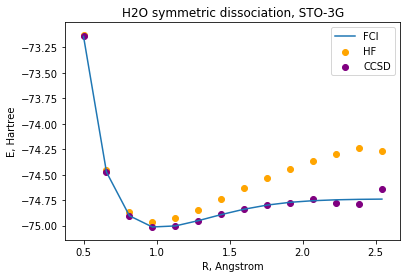

In [11]:
#Plot H2O PESs

plt.title('H2O symmetric dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

## LiH

In [12]:
bond_lengths = np.linspace(0.8,2.8,16)
bond_lengths

array([0.8       , 0.93333333, 1.06666667, 1.2       , 1.33333333,
       1.46666667, 1.6       , 1.73333333, 1.86666667, 2.        ,
       2.13333333, 2.26666667, 2.4       , 2.53333333, 2.66666667,
       2.8       ])

In [13]:
#Run FCI
FCI_PES = obtain_PES('lih', bond_lengths, basis, method='fci')

E = -7.634167329728353 Eh
E = -7.746437307917992 Eh
E = -7.813663001648543 Eh
E = -7.852430853316401 Eh
E = -7.872954613066121 Eh
E = -7.881561154690024 Eh
E = -7.882324378871222 Eh
E = -7.8779861036096 Eh
E = -7.8704542635636425 Eh
E = -7.861087772411142 Eh
E = -7.850873228128551 Eh
E = -7.840539781724128 Eh
E = -7.830631624342838 Eh
E = -7.821546418772919 Eh
E = -7.8135473668328395 Eh
E = -7.806763402503807 Eh


In [14]:
#Run HF
HF_PES = obtain_PES('lih', bond_lengths, basis,  method='hf')

E = -7.615847732045305 Eh
E = -7.729058439406403 Eh
E = -7.796878661258512 Eh
E = -7.835694662390294 Eh
E = -7.855646916153798 Eh
E = -7.8630437492307195 Eh
E = -7.861950402903201 Eh
E = -7.855090010439479 Eh
E = -7.844336397587627 Eh
E = -7.830998803612782 Eh
E = -7.816001266637411 Eh
E = -7.800003987733569 Eh
E = -7.783488814132521 Eh
E = -7.766819652396688 Eh
E = -7.7502831908545105 Eh
E = -7.734113419610024 Eh


In [15]:
#Run CCSD
CCSD_PES = obtain_PES('lih', bond_lengths, basis,  method='ccsd')

E = -7.634160527656569 Eh
E = -7.746430970506597 Eh
E = -7.813656291158955 Eh
E = -7.8524234479693265 Eh
E = -7.8729459612179955 Eh
E = -7.881550790015216 Eh
E = -7.882312097529623 Eh
E = -7.877971932703345 Eh
E = -7.870438116706994 Eh
E = -7.861069226073766 Eh
E = -7.850851475406808 Eh
E = -7.840513597143466 Eh
E = -7.830599382289906 Eh
E = -7.8215062104563815 Eh
E = -7.81349731484278 Eh
E = -7.806702090929714 Eh


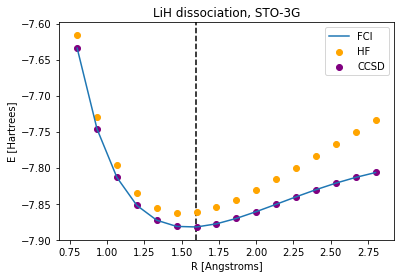

In [16]:
#Plot PESs
fig = plt.figure()

plt.title('LiH dissociation, STO-3G')
plt.xlabel('R [Angstroms]')
plt.ylabel('E [Hartrees]')

plt.axvline(x=1.595, color='k', linestyle='--', zorder=0) #experimental bond length from cccbdb.nist.gov
plt.plot(bond_lengths, FCI_PES, label='FCI', zorder=3)
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange', zorder=1)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple', zorder=2)
plt.legend()

fig.savefig('lih.png', bbox_inches='tight')

## N<sub>2</sub>

In [17]:
bond_lengths = np.linspace(0.5,1.9,12)
bond_lengths

array([0.5       , 0.62727273, 0.75454545, 0.88181818, 1.00909091,
       1.13636364, 1.26363636, 1.39090909, 1.51818182, 1.64545455,
       1.77272727, 1.9       ])

In [18]:
#Run FCI
FCI_PES = obtain_PES('n2', bond_lengths, basis, method='fci')

E = -100.61161345806086 Eh
E = -104.5439505925683 Eh
E = -106.38679440740637 Eh
E = -107.22199300609087 Eh
E = -107.5637595184171 Eh
E = -107.66939661841205 Eh
E = -107.66894381424773 Eh
E = -107.62682902497575 Eh
E = -107.57413956320788 Eh
E = -107.52599089834432 Eh
E = -107.4895238158692 Eh
E = -107.46611285370918 Eh


In [19]:
#Run HF
HF_PES = obtain_PES('n2', bond_lengths, basis,  method='hf')

E = -100.57326037643408 Eh
E = -104.48880997431704 Eh
E = -106.3098938890539 Eh
E = -107.12029741068967 Eh
E = -107.4318685267734 Eh
E = -107.50086585741016 Eh
E = -107.45719519775983 Eh
E = -107.36547630636021 Eh
E = -107.25676565692623 Eh
E = -107.14567517832874 Eh
E = -107.03933857861772 Eh
E = -106.94147584489657 Eh


In [20]:
#Run CCSD
CCSD_PES = obtain_PES('n2', bond_lengths, basis,  method='ccsd')

E = -100.61133467693008 Eh
E = -104.54341589058836 Eh
E = -106.38585228864133 Eh
E = -107.22041183119202 Eh
E = -107.5610799720012 Eh
E = -107.66483215637736 Eh
E = -107.66143262171173 Eh
E = -107.6155680567117 Eh
E = -107.560209220206 Eh
E = -107.51599822532162 Eh
E = -107.50095259819435 Eh
E = -107.5251948911921 Eh


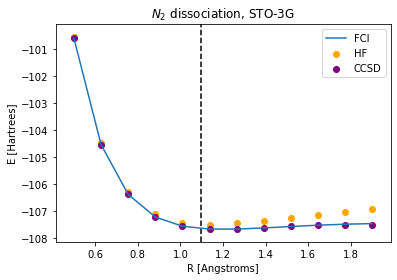

In [21]:
#Plot PESs
fig = plt.figure()

plt.title('$N_2$ dissociation, STO-3G')
plt.xlabel('R [Angstroms]')
plt.ylabel('E [Hartrees]')

plt.axvline(x=1.098, color='k', linestyle='--', zorder=0) #experimental bond length from cccbdb.nist.gov
plt.plot(bond_lengths, FCI_PES, label='FCI', zorder=3)
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange', zorder=1)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple', zorder=2)
plt.legend()

fig.savefig('n2.png', bbox_inches='tight')